In [101]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download("words")
from nltk.corpus import words
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import gensim
from gensim.models import Word2Vec
from scipy.sparse import hstack, csr_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from nltk.probability import FreqDist

nltk.download("omw-1.4")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")

[nltk_data] Downloading package words to /Users/pnawn/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/pnawn/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/pnawn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/pnawn/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/pnawn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [102]:
df = pd.read_excel("GL dataset.xlsx")
df.head()

,lineDescription,localAmount,PostDate,Group Acctnum
0,"Reverses ""AL- ACCR- RECURRING CHARGES FOR DEC ...",3080.0,2015-01-08,32
1,"Reverses ""AL- ACCR- RECURRING CHARGES FOR DEC ...",-1780.0,2015-01-08,62
2,"Reverses ""AL- ACCR- RECURRING CHARGES FOR DEC ...",-700.0,2015-01-08,62
3,"Reverses ""AL- ACCR- RECURRING CHARGES FOR DEC ...",-600.0,2015-01-08,62
4,"Reverses ""AL- ACCR- ELECTRICITY CHRGS FOR DEC ...",4000.0,2015-01-08,32


In [103]:
df = df.groupby("Group Acctnum").filter(lambda x: len(x) >= 12)

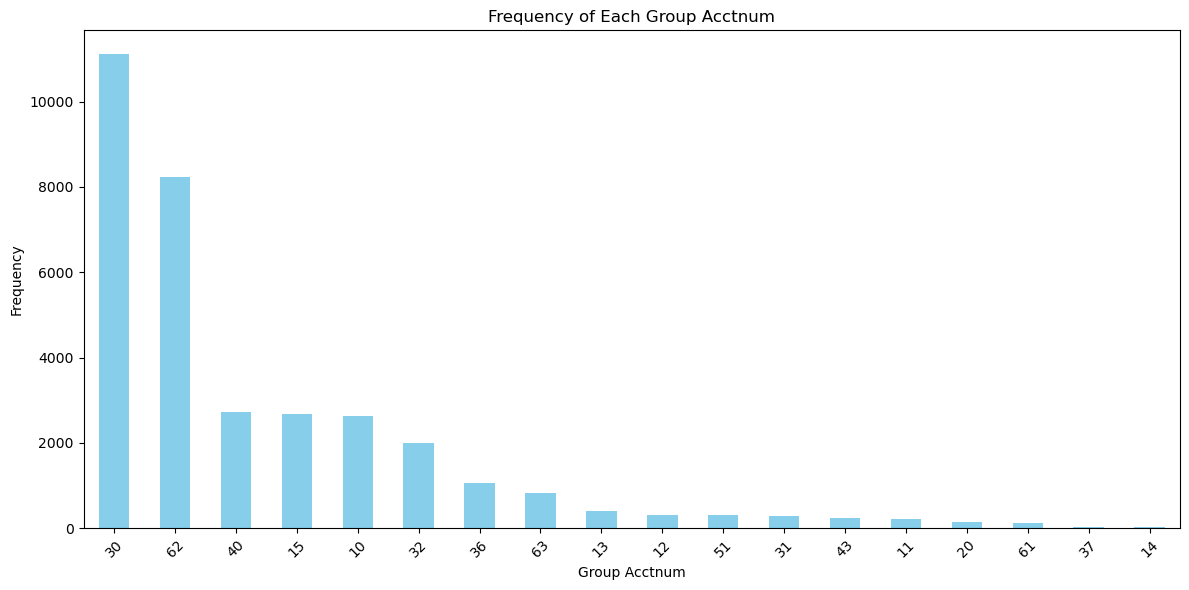

In [104]:
group_acctnum_counts = df["Group Acctnum"].value_counts()

plt.figure(figsize=(12, 6))
group_acctnum_counts.plot(kind="bar", color="skyblue")
plt.title("Frequency of Each Group Acctnum")
plt.xlabel("Group Acctnum")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [105]:
df["day_range"] = df["PostDate"].dt.day.apply(lambda x: 0 if x <= 10 else (1 if x <= 20 else 2))

In [106]:
df["is_dr"] = df["localAmount"].apply(lambda x: 1 if x >= 0 else 0)

In [107]:
df.loc[df["Group Acctnum"] == 30, "lineDescription"] = df["lineDescription"] + " payable"

In [108]:
import string

string.punctuation


def remove_punctuation(text):
    punctutationfree = "".join([i for i in text if i not in string.punctuation])
    return punctutationfree


df["LiDesc_clean"] = df["lineDescription"].apply(lambda x: remove_punctuation(x))
df.head()

,lineDescription,localAmount,PostDate,Group Acctnum,day_range,is_dr,LiDesc_clean
0,"Reverses ""AL- ACCR- RECURRING CHARGES FOR DEC ...",3080.0,2015-01-08,32,0,1,Reverses AL ACCR RECURRING CHARGES FOR DEC 201...
1,"Reverses ""AL- ACCR- RECURRING CHARGES FOR DEC ...",-1780.0,2015-01-08,62,0,0,Reverses AL ACCR RECURRING CHARGES FOR DEC 201...
2,"Reverses ""AL- ACCR- RECURRING CHARGES FOR DEC ...",-700.0,2015-01-08,62,0,0,Reverses AL ACCR RECURRING CHARGES FOR DEC 201...
3,"Reverses ""AL- ACCR- RECURRING CHARGES FOR DEC ...",-600.0,2015-01-08,62,0,0,Reverses AL ACCR RECURRING CHARGES FOR DEC 201...
4,"Reverses ""AL- ACCR- ELECTRICITY CHRGS FOR DEC ...",4000.0,2015-01-08,32,0,1,Reverses AL ACCR ELECTRICITY CHRGS FOR DEC 201...


In [109]:
df["LiDesc_clean"] = df["LiDesc_clean"].str.lower()

In [110]:
# define function for tokenization


def tokenization(text):
    tokens = word_tokenize(text)
    return tokens


df["LiDesc_clean"] = df["LiDesc_clean"].apply(lambda x: tokenization(x))

In [111]:
# remove stop words

stopwords = nltk.corpus.stopwords.words("english")
stopwords[0:10]
if "other" in stopwords:
    stopwords.remove("other")

# define function to remove stopwords from tokenized text


def remove_stopwords(text):
    output = [i for i in text if i not in stopwords]
    return output


df["LiDesc_clean"] = df["LiDesc_clean"].apply(lambda x: remove_stopwords(x))

In [112]:
df["LiDesc_clean"] = df["LiDesc_clean"].apply(lambda words: [word for word in words if len(word) > 2])

In [113]:
# defining the object for Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()


# defining the function for lemmatization
def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text


df["LiDesc_clean"] = df["LiDesc_clean"].apply(lambda x: lemmatizer(x))

In [114]:
english_words = set(words.words())


def filter_non_dictionary_words(text):
    # Ensure the text is a list of words
    if isinstance(text, str):
        text = word_tokenize(text)

    return [word for word in text if word.lower() in english_words]


df["LiDesc_clean"] = df["LiDesc_clean"].apply(lambda x: filter_non_dictionary_words(x))

In [115]:
df = df.query("LiDesc_clean != ''")

## Split train test

In [116]:
df["LiDesc_clean"] = df["LiDesc_clean"].str.join(" ")

In [117]:
X = df.drop(columns=["Group Acctnum"])
y = df["Group Acctnum"]

In [118]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)

In [119]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_transformed = vectorizer.fit_transform(X_train["LiDesc_clean"])

In [120]:
X_test_transformed = vectorizer.transform(X_test["LiDesc_clean"])

In [121]:
tfidf_df = pd.DataFrame(X_transformed.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df.head()

,access,accident,accommodation,account,accretion,accrual,accrue,acquired,acquisition,acrylic,...,wrong,wrongly,yan,yang,year,yee,yen,young,yr,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.443081,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [122]:
# Combine matrix for X_train
other_features = csr_matrix(X_train[["is_dr", "day_range"]].values)
combined_matrix = hstack([X_transformed, other_features])

In [123]:
# Combine matrix for X_test
other_features_X_test = csr_matrix(X_test[["is_dr", "day_range"]].values)
combined_matrix_X_test = hstack([X_test_transformed, other_features_X_test])

In [124]:
X_train = combined_matrix
X_test = combined_matrix_X_test

In [125]:
from sklearn.linear_model import LogisticRegression

In [126]:
lr = LogisticRegression(multi_class="multinomial")
lr.fit(X_train, y_train)

/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [127]:
lr_y_pred = lr.predict(X_test)

In [128]:
print(classification_report(y_test, lr_y_pred))

              precision    recall  f1-score   support

          10       0.88      0.88      0.88       525
          11       0.46      0.71      0.56        42
          12       0.53      0.66      0.59        62
          13       0.73      0.30      0.42        81
          14       1.00      0.75      0.86         4
          15       0.76      0.55      0.64       536
          20       0.86      0.59      0.70        32
          30       1.00      1.00      1.00      2222
          31       0.50      0.25      0.34        59
          32       0.74      0.50      0.60       398
          36       0.58      0.56      0.57       214
          37       0.00      0.00      0.00         5
          40       0.93      0.88      0.90       543
          43       0.98      0.88      0.93        50
          51       0.60      0.39      0.47        62
          61       0.67      0.09      0.15        23
          62       0.73      0.93      0.82      1645
          63       0.78    

/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


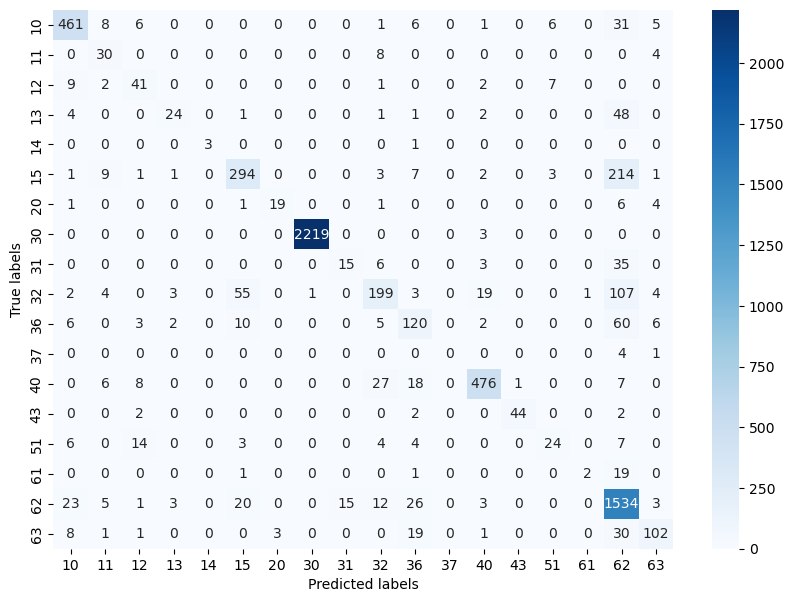

In [129]:
unique_labels = sorted(np.unique(np.concatenate([y_test, lr_y_pred])))
# Compute confusion matrix with explicit labels
lr_cm = confusion_matrix(y_test, lr_y_pred, labels=unique_labels)
# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(lr_cm, annot=True, fmt="g", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()